In [1]:
!pip install timm

In [2]:
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
import glob
import numpy
import numpy as np
from fastai.vision.all import *
from pathlib import Path
import timm

In [3]:
def get_image(image_path: str) -> numpy.ndarray:
    return cv2.imread(image_path)

In [4]:
# Takes both path and ndarray as input
def show_image(image):
    if type(image) == str:
        plt.imshow(cv2.imread(image))
    else:
        plt.imshow(image)

In [5]:
def save_image(target_path: str):
    # Todo
    pass

In [6]:
# Takes both path and ndarray as input
def show_images_in_grid(*images: str | numpy.ndarray, window_name: str = "Grid Display", grid_size=(2, 2), image_names: list = None, cmap: str = None):
    total_images = len(images)
    rows, cols = grid_size

    if total_images != rows * cols:
        raise ValueError(f"Expected {rows * cols} images, but got {total_images}")

    fig, axes = plt.subplots(rows, cols)
    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            ax = axes[i][j] if rows != 1 else axes[index]
            ax.imshow(cv2.imread(images[index]) if type(images[index]) == str else images[index], cmap)
            if image_names is not None:
                ax.set_title(image_names[index])
    plt.tight_layout()
    plt.show()

# Initialisation and Pre-Processing

In [7]:
# Getting hold of all infected/uninfected images
dataset_base_directory = "/kaggle/input/cell-images-for-detecting-malaria/cell_images"
infected_folder = dataset_base_directory + "/Parasitized"
uninfected_folder = dataset_base_directory + "/Uninfected"
infected_images = glob.glob(infected_folder + "/*.png")
uninfected_images = glob.glob(uninfected_folder + "/*.png")
infected_number = len(infected_images)
uninfected_number = len(uninfected_images)
print('# Infected photos: ', infected_number)
print('# Uninfected photos: ', uninfected_number)

# Infected photos:  13779
# Uninfected photos:  13779


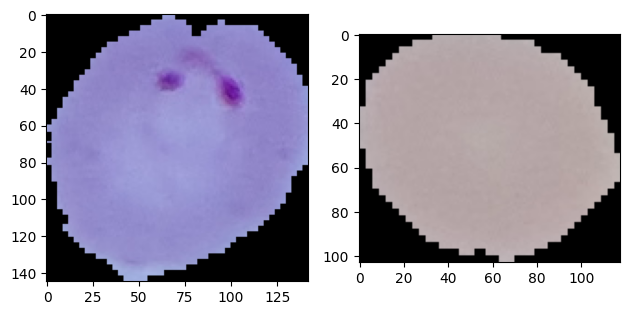

In [8]:
example_infected = infected_images[1]
example_uninfected = uninfected_images[1]
# Example usage of the function
show_images_in_grid(get_image(example_infected), example_uninfected, grid_size=(1, 2))

In [9]:
from skimage.morphology import closing, disk

def process_image(image_path: str) -> dict[str, numpy.ndarray]:
    image_BGR = get_image(image_path)
    binary_mask = cv2.split(image_BGR)[0]
    ret, binary_mask = cv2.threshold(binary_mask, 10, 255, cv2.THRESH_BINARY)
    ret, binary_green = cv2.threshold(cv2.split(image_BGR)[1], 100, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3,3),np.uint8)
    binary_mask = cv2.erode(binary_mask, kernel, iterations = 1)
    green_diff = cv2.subtract(binary_mask, binary_green)
    green_diff_canny = cv2.Canny(green_diff, 40, 40)
    green = cv2.split(image_BGR)[1]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    green_contrast = clahe.apply(green)
    green_diff_median = cv2.medianBlur(green_diff, 5)

    se = disk(6)
    green_diff_closed = closing(green_diff_median, se)

    ## Erthorcyte Thresholding
    # Assuming 'green_diff_closed' is the processed image
    green_complement = green_diff_closed
    # Calculate the histogram of the complemented green component
    hist, bins = np.histogram(green_complement.flatten(), bins=256, range=[0, 256])
    # Calculate the cumulative distribution function (CDF) of the histogram
    cdf = hist.cumsum()
    # Normalize the CDF to range [0, 1]
    cdf_normalized = cdf / cdf.max()
    # Initialize variables for Otsu's method
    max_var, threshold = 0, 0
    # Iterate over intensity values to find the optimal threshold
    for i in range(1, len(cdf_normalized)):
        w0 = cdf_normalized[i]
        w1 = 1 - w0

        mu0 = np.sum(np.arange(i) * hist[:i]) / (np.sum(hist[:i]) + 1e-10)
        mu1 = np.sum(np.arange(i, 256) * hist[i:]) / (np.sum(hist[i:]) + 1e-10)

        var_between = w0 * w1 * (mu0 - mu1)**2

        if var_between > max_var:
            max_var = var_between
            threshold = i
    # Apply the threshold to separate erythrocytes from the background
    erythrocyte_mask = green_complement > threshold

    return {
        'green_diff':green_diff,
        'green_diff_canny':green_diff_canny,
        'green_contrast': green_contrast,
        'green_diff_median':  green_diff_median,
		'green_diff_closed': green_diff_closed, # same as green complement
        'erythrocyte_mask': erythrocyte_mask.astype(np.uint8) * 255
    }

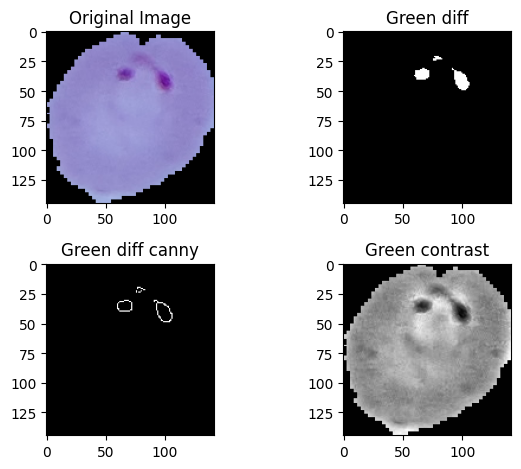

In [10]:
green_diff = process_image(infected_images[1])['green_diff']
green_diff_canny = process_image(infected_images[1])['green_diff_canny']
green_contrast = process_image(infected_images[1])['green_contrast']
show_images_in_grid(
    infected_images[1], green_diff, green_diff_canny, green_contrast,
    grid_size=(2, 2),
    image_names=['Original Image', 'Green diff', 'Green diff canny', 'Green contrast'],
    cmap='gray'
)

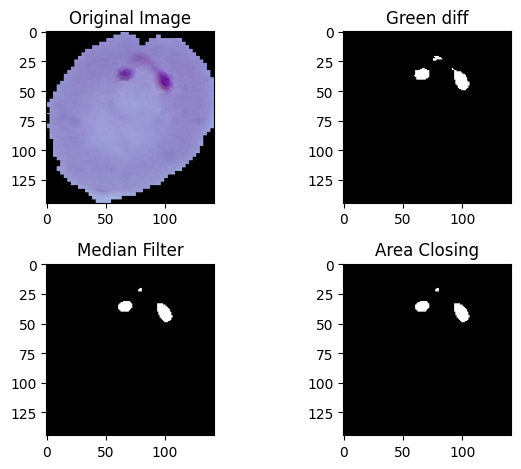

In [11]:
from skimage.morphology import closing, disk

# Assuming 'process_image' returns the processed image as 'green_diff'
green_diff = process_image(infected_images[1])['green_diff']

# Apply a 5x5 median filter
green_diff_median = cv2.medianBlur(green_diff, 5)

# Define a disk-shaped structuring element for morphological operations
se = disk(6)

# Apply morphological area closing using the disk-shaped structuring element
green_diff_closed = closing(green_diff_median, se)

# Display the original and processed images in a grid
show_images_in_grid(
    infected_images[1], green_diff, green_diff_median, green_diff_closed,
    grid_size=(2, 2),
    image_names=['Original Image', 'Green diff', 'Median Filter', 'Area Closing'],
    cmap='gray'
)

In [12]:
from skimage import measure, morphology

# Function to calculate pattern spectrum using granulometry
def calculate_pattern_spectrum(image):
    pattern_spectrum = []
    sizes = range(1, 20)  # Adjust the range of sizes as needed

    for size in sizes:
        # Apply morphological opening with a disk-shaped structuring element
        se = morphology.disk(size)
        opened = morphology.binary_opening(image, se)

        # Calculate the difference in morphological openings
        pattern_spectrum.append(np.sum(opened) / np.sum(image))

    return pattern_spectrum

# Function to determine the average eccentricity of erythrocytes
def calculate_average_eccentricity(binary_image):
    # Label connected components in the binary image
    labeled_cells = measure.label(binary_image)

    # Calculate mean and standard deviation of the radius determined by granulometry
    granulometry_result = calculate_pattern_spectrum(binary_image)
    radius_values = np.arange(1, 20)
    mean_radius = np.sum(np.array(radius_values) * np.array(granulometry_result))
    std_radius = np.sqrt(np.sum((np.array(radius_values) - mean_radius)**2 * np.array(granulometry_result)))

    # Threshold for free-standing erythrocytes
    threshold_area = np.pi * (mean_radius + std_radius)**2

    # Calculate eccentricity for free-standing erythrocytes only
    eccentricities = []
    for region in measure.regionprops(labeled_cells):
        if region.area > threshold_area:
            eccentricities.append(region.eccentricity)

    # Calculate average eccentricity
    if eccentricities:
        average_eccentricity = np.mean(eccentricities)
    else:
        average_eccentricity = 0  # Default value if no free-standing erythrocytes are found

    return average_eccentricity

# Now, let's calculate the pattern spectrum and average eccentricity for 'green_diff_closed'
pattern_spectrum_result = calculate_pattern_spectrum(green_diff_closed)
average_eccentricity_result = calculate_average_eccentricity(green_diff_closed)

# Print or use the results as needed
print("Pattern Spectrum:", pattern_spectrum_result)
print("Average Eccentricity:", average_eccentricity_result)

Pattern Spectrum: [0.003855935679711215, 0.003708261547296743, 0.003576995651817212, 0.0034293215194027404, 0.0013290671917302486, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Average Eccentricity: 0.7018222076718453


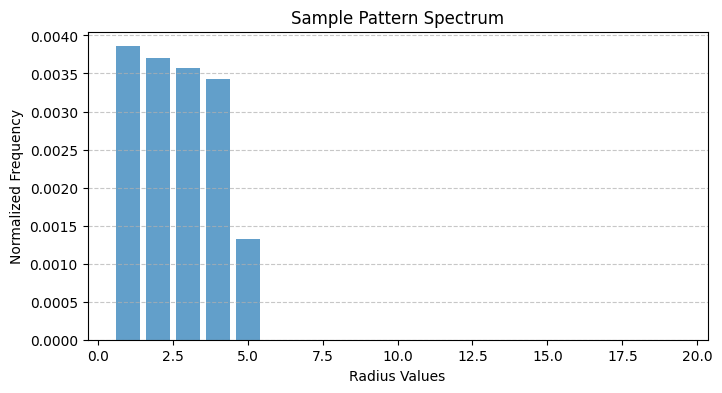

In [13]:
from skimage.morphology import closing, disk

# Plot the sample pattern spectrum using a bar histogram
radius_values = np.arange(1, len(pattern_spectrum_result) + 1)
normalized_frequency = np.array(pattern_spectrum_result)

plt.figure(figsize=(8, 4))
plt.bar(radius_values, normalized_frequency, align='center', alpha=0.7)
plt.title('Sample Pattern Spectrum')
plt.xlabel('Radius Values')
plt.ylabel('Normalized Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

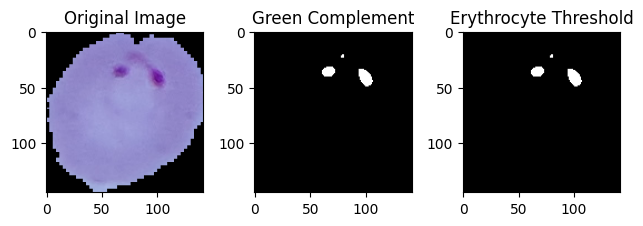

In [14]:
# Assuming 'green_diff_closed' is the processed image
green_complement = green_diff_closed

# Calculate the histogram of the complemented green component
hist, bins = np.histogram(green_complement.flatten(), bins=256, range=[0, 256])

# Calculate the cumulative distribution function (CDF) of the histogram
cdf = hist.cumsum()

# Normalize the CDF to range [0, 1]
cdf_normalized = cdf / cdf.max()

# Initialize variables for Otsu's method
max_var, threshold = 0, 0

# Iterate over intensity values to find the optimal threshold
for i in range(1, len(cdf_normalized)):
    w0 = cdf_normalized[i]
    w1 = 1 - w0

    mu0 = np.sum(np.arange(i) * hist[:i]) / (np.sum(hist[:i]) + 1e-10)
    mu1 = np.sum(np.arange(i, 256) * hist[i:]) / (np.sum(hist[i:]) + 1e-10)

    var_between = w0 * w1 * (mu0 - mu1)**2

    if var_between > max_var:
        max_var = var_between
        threshold = i

# Apply the threshold to separate erythrocytes from the background
erythrocyte_mask = green_complement > threshold

# Display the original and processed images along with the thresholded result
show_images_in_grid(
    infected_images[1], green_complement, erythrocyte_mask.astype(np.uint8) * 255,
    grid_size=(1, 3),
    image_names=['Original Image', 'Green Complement', 'Erythrocyte Threshold'],
    cmap='gray'
)

# Saving the images

In [15]:
import os
try:
	os.mkdir("/kaggle/working/parasatized/")
except:
	print("Directory already exists")
try:
	os.mkdir("/kaggle/working/uninfected/")
except:
	print("Directory already exists")

Directory already exists
Directory already exists


In [16]:
# from tqdm import tqdm

# # Saving parasitized images and their types
# processed_parasatized_directory = "/kaggle/working/parasatized/"
# for index, image_path in enumerate(tqdm(infected_images, desc="Processing Parasitized Images")):
#     # Getting the images
#     green_based_filtering_dict = process_image(image_path)
#     erythrocyte_mask = green_based_filtering_dict['erythrocyte_mask']

#     # Saving them
#     cv2.imwrite(f"{processed_parasatized_directory}{index}_erythrocyte_mask.png", erythrocyte_mask)

# # Saving uninfected images and their types
# processed_uninfected_directory = "/kaggle/working/uninfected/"
# for index, image_path in enumerate(tqdm(uninfected_images, desc="Processing Uninfected Images")):
#     # Getting the images
#     green_based_filtering_dict = process_image(image_path)
#     erythrocyte_mask = green_based_filtering_dict['erythrocyte_mask']

#     # Saving them
#     cv2.imwrite(f"{processed_uninfected_directory}{index}_erythrocyte_mask.png", erythrocyte_mask)


Processing Uninfected Images: 100%|██████████| 13779/13779 [08:49<00:00, 26.04it/s]


In [ ]:
# # Saving parasatized images and their types
# processed_parasatized_directory = "/kaggle/working/parasatized/"
# for index, image_path in enumerate(infected_images):
#     # Getting the images
#     green_based_filtering_dict = process_image(image_path)
# #     green_diff = green_based_filtering_dict['green_diff']
# #     green_diff_canny = green_based_filtering_dict['green_diff_canny']
# #     green_contrast = green_based_filtering_dict['green_contrast']
#     erythrocyte_mask = green_based_filtering_dict['erythrocyte_mask']

#     # Saving them
# #     cv2.imwrite(f"{processed_parasatized_directory}{index}_green_diff.png", green_diff)
# #     cv2.imwrite(f"{processed_parasatized_directory}{index}_green_diff_canny.png", green_diff_canny)
# #     cv2.imwrite(f"{processed_parasatized_directory}{index}_green_contrast.png", green_contrast)
#     cv2.imwrite(f"{processed_parasatized_directory}{index}_erythrocyte_mask.png", erythrocyte_mask)

# # Saving infected images and their types
# processed_uninfected_directory = "/kaggle/working/uninfected/"
# for index, image_path in enumerate(uninfected_images):
#     # Getting the images
#     green_based_filtering_dict = process_image(image_path)
# #     green_diff = green_based_filtering_dict['green_diff']
# #     green_diff_canny = green_based_filtering_dict['green_diff_canny']
# #     green_contrast = green_based_filtering_dict['green_contrast']
#     erythrocyte_mask = green_based_filtering_dict['erythrocyte_mask']

#     # Saving them
# #     cv2.imwrite(f"{processed_uninfected_directory}{index}_green_diff.png", green_diff)
# #     cv2.imwrite(f"{processed_uninfected_directory}{index}_green_diff_canny.png", green_diff_canny)
# #     cv2.imwrite(f"{processed_uninfected_directory}{index}_green_contrast.png", green_contrast)
#     cv2.imwrite(f"{processed_parasatized_directory}{index}_erythrocyte_mask.png", erythrocyte_mask)

# Neural Network

In [15]:
# Assuming you have already defined the path
parasitized_folder = Path("/kaggle/working/parasatized/")

# Get the first 5 images in the parasitized folder
first_five_images = list(parasitized_folder.glob("*erythrocyte_mask.png"))[:5]

# Print the names of the first 5 images
for image_path in first_five_images:
    print(image_path.name)

7892_erythrocyte_mask.png
9560_erythrocyte_mask.png
247_erythrocyte_mask.png
9141_erythrocyte_mask.png
11751_erythrocyte_mask.png


In [16]:
# Assuming you have a folder path
folder_path = Path("/kaggle/working/uninfected/")

# Get all images in the folder that contain the string "8111" in their names
matching_images = [image_path for image_path in folder_path.glob("*") if "8111" in image_path.name]

# Print the names of matching images
for image_path in matching_images:
    print(image_path.name)


8111_green_diff_canny.png
8111_green_contrast.png
8111_green_diff.png
8111_erythrocyte_mask.png


## One single, but big model

In [ ]:
# pth = Path('/kaggle/working/')
# db = DataBlock(
#     blocks=(ImageBlock, CategoryBlock), 
#     get_items=get_image_files, 
#     splitter=RandomSplitter(valid_pct=0.2, seed=42),
#     get_y=parent_label,
#     item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode='zeros'),
#     batch_tfms=aug_transforms()  # Add your batch transforms here
# )

In [ ]:
# men = db.dataloaders(pth)

In [ ]:
# men.show_batch()

In [ ]:
# main = vision_learner(men, 'levit_384',  pretrained = True, metrics=accuracy)

In [ ]:
# main.fine_tune(10)

## 4 different small models

In [17]:
pth = Path('/kaggle/working/')
# Define the paths
def get_green_diff_images(path):
    return [img for img in get_image_files(path) if img.name.endswith('green_diff.png')]
def get_green_canny_images(path):
    return [img for img in get_image_files(path) if img.name.endswith('green_diff_canny.png')]
def get_green_contrast_images(path):
    return [img for img in get_image_files(path) if img.name.endswith('green_contrast.png')]
def get_erythrocyte_mask_images(path):
    return [img for img in get_image_files(path) if img.name.endswith('erythrocyte_mask.png')]

# Now you can use this function in your data block
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_green_diff_images, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode='zeros'),
)
data_block_2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_green_canny_images, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode='zeros'),
)
data_block_3 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_green_contrast_images, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode='zeros'),
)
data_block_4 = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_erythrocyte_mask_images, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, method=ResizeMethod.Pad, pad_mode='zeros'),
)

# Load the data and store the dataloader in a separate variable
green_diff = data_block.dataloaders(pth)
green_canny = data_block_2.dataloaders(pth)
green_contrast = data_block_3.dataloaders(pth)
erythrocyte_mask = data_block_4.dataloaders(pth)

In [18]:
# model = vision_learner(green_diff, 'levit_conv_256',  pretrained = False, metrics=accuracy).to_fp16()
# model2 = vision_learner(green_canny, 'levit_conv_256',  pretrained = False, metrics=accuracy).to_fp16()
# model3 = vision_learner(green_contrast, 'levit_conv_256',  pretrained = False, metrics=accuracy).to_fp16()
# model4 = vision_learner(erythrocyte_mask, 'levit_conv_256',  pretrained = False, metrics=accuracy).to_fp16()

In [19]:
# model.lr_find()

In [20]:
# model2.lr_find()

In [ ]:
# model3.lr_find()

SuggestedLRs(valley=0.0003311311302240938)

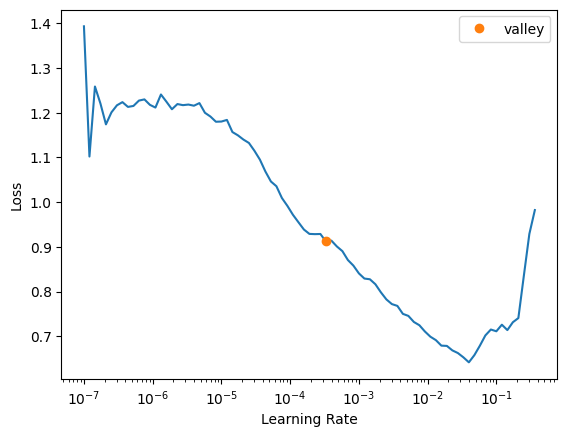

In [5]:
# model4.lr_find()

In [ ]:
# model.fine_tune(18, base_lr = 0.0010000000474974513)

In [ ]:
# model2.fine_tune(18, base_lr = 0.0002754228771664202)

In [ ]:
# model3.fine_tune(18, base_lr = 0.009120108559727669)

In [6]:
# model4.fine_tune(18, base_lr = 0.0003311311302240938)

epoch,train_loss,valid_loss,accuracy,time
0,0.388301,0.293388,0.922519,00:59


epoch,train_loss,valid_loss,accuracy,time
0,0.355526,0.275886,0.922337,01:07
1,0.317020,0.281023,0.925059,01:07
2,0.314250,0.281495,0.928507,01:07
3,0.300367,0.251060,0.930503,01:07
4,0.316104,0.273280,0.928144,01:07
5,0.274033,0.262245,0.929595,01:07
6,0.295929,0.247386,0.932680,01:08
7,0.266341,0.234384,0.937942,01:07
8,0.257767,0.234916,0.938305,01:07
9,0.249162,0.234411,0.934858,01:07


In [7]:
# model.export('green_diff.pkl')
# model2.export('green_canny.pkl')
# model3.export('green_contrast.pkl')
# model4.export('erythrocyte_mask.pkl')

In [21]:
model = load_learner('/kaggle/working/green_diff.pkl')
model2 = load_learner('/kaggle/working/green_canny.pkl')
model3 = load_learner('/kaggle/working/green_contrast.pkl')
model4 = load_learner('/kaggle/working/erythrocyte_mask.pkl')

# Inference

In [ ]:
# Get the predictions from each model
preds1, targets = model.get_preds(dl=green_diff.valid)
preds2, _ = model2.get_preds(dl=green_canny.valid)
preds3, _ = model3.get_preds(dl=green_contrast.valid)
preds4, _ = model4.get_preds(dl=erythrocyte_mask.valid)
# Combine the predictions (here we use averaging)
combined_preds = (preds1 + preds2 + preds3 + preds4) / 4

# Calculate the accuracy
accuracy = (combined_preds.argmax(dim=1) == targets).float().mean()

# Convert tensors to numpy arrays for scikit-learn compatibility
targets_np = targets.numpy()
combined_preds_np = combined_preds.argmax(dim=1).numpy()

# Calculate the F1 score
f1 = f1_score(targets_np, combined_preds_np, average='weighted')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(targets_np, combined_preds_np)

print(f'Test accuracy: {accuracy.item()}')
print(f'F1 score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

In [26]:
def process_and_predict(image_path: str, model, model2, model3, model4) -> None:
    # Process the image
    processed_images = process_image(image_path)  # Assuming this is done outside the function now

    # Convert processed images to fastai Image tensors
    green_diff_img = processed_images['green_diff']
    green_diff_canny_img = processed_images['green_diff_canny']
    green_contrast_img = processed_images['green_contrast']
    erythrocyte_mask_img = processed_images['erythrocyte_mask']  # New line

    # Convert to 3 channel image and resize
    green_diff_img_3ch = np.stack((green_diff_img,)*3, axis=-1)
    green_diff_img_3ch = Image.fromarray(green_diff_img_3ch)
    green_diff_img_3ch = green_diff_img_3ch.resize((224, 224))
    green_diff_img_3ch = np.array(green_diff_img_3ch)

    green_diff_canny_img_3ch = np.stack((green_diff_canny_img,)*3, axis=-1)
    green_diff_canny_img_3ch = Image.fromarray(green_diff_canny_img_3ch)
    green_diff_canny_img_3ch = green_diff_canny_img_3ch.resize((224, 224))
    green_diff_canny_img_3ch = np.array(green_diff_canny_img_3ch)

    green_contrast_img_3ch = np.stack((green_contrast_img,)*3, axis=-1)
    green_contrast_img_3ch = Image.fromarray(green_contrast_img_3ch)
    green_contrast_img_3ch = green_contrast_img_3ch.resize((224, 224))
    green_contrast_img_3ch = np.array(green_contrast_img_3ch)

    erythrocyte_mask_img_3ch = np.stack((erythrocyte_mask_img,)*3, axis=-1)  # New line
    erythrocyte_mask_img_3ch = Image.fromarray(erythrocyte_mask_img_3ch)  # New line
    erythrocyte_mask_img_3ch = erythrocyte_mask_img_3ch.resize((224, 224))  # New line
    erythrocyte_mask_img_3ch = np.array(erythrocyte_mask_img_3ch)  # New line

    # Get predictions from each model
    preds1, num1, prob1 = model.predict(green_diff_img_3ch)
    preds2, num2, prob2 = model2.predict(green_diff_canny_img_3ch)
    preds3, num3, prob3 = model3.predict(green_contrast_img_3ch)
    preds4, num4, prob4 = model4.predict(erythrocyte_mask_img_3ch)  # New line

    # Convert tensors to numpy arrays and get class predictions
    num1 = num1.numpy()
    num2 = num2.numpy()
    num3 = num3.numpy()
    num4 = num4.numpy()  # New line
    # Combine the predictions (here we use averaging)
    combined_preds = (num1 + num2 + num3 + num4) / 4  # Modified line

    # Get the predicted class and confidence
    predicted_class = 'Uninfected' if int(combined_preds) == 1 else 'Parasitized'
    
    # Calculate the average probability
    avg_prob = (prob1[num1] + prob2[num2] + prob3[num3] + prob4[num4]) / 4  # Modified line
    # Display the prediction and confidence
    print(f'Predicted Class: {predicted_class}')
    print(f'Confidence: {avg_prob * 100:.2f}%')
    return int(combined_preds)

image_path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png"
process_and_predict(image_path, model, model2, model3, model4)

Predicted Class: Parasitized
Confidence: 91.94%


0

In [27]:
import os
import random
from sklearn.metrics import f1_score

def calculate_accuracy_and_f1(testing_folder: str, model, model2, model3, model4) -> None:
    subfolders = ['Parasitized', 'Uninfected']
    correct_predictions = 0
    total_predictions = 0

    y_true = []
    y_pred = []
    random.seed(42)
    for subfolder in subfolders:
        # Get all images in the subfolder
        image_files = os.listdir(os.path.join(testing_folder, subfolder))
        
        # Randomly select 20 images
        selected_images = random.sample(image_files, 100)

        for image_file in selected_images:
            image_path = os.path.join(testing_folder, subfolder, image_file)

            # Use your process_and_predict function to make a prediction
            predicted_class = process_and_predict(image_path, model, model2, model3, model4)

            # Check if the prediction is correct (assuming that 'Parasitized' is class 0 and 'Uninfected' is class 1)
            actual_class = 0 if subfolder == 'Parasitized' else 1
            if predicted_class == actual_class:
                correct_predictions += 1

            total_predictions += 1

            # Add the actual and predicted classes to the lists
            y_true.append(actual_class)
            y_pred.append(predicted_class)

    # Calculate and print the testing accuracy
    accuracy = correct_predictions / total_predictions
    print(f'Testing Accuracy: {accuracy * 100:.2f}%')

    # Calculate and print the F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f'F1 Score: {f1:.2f}')

# Example usage:
testing_folder = '/kaggle/input/files1/Malaria Cells/testing_set'
calculate_accuracy_and_f1(testing_folder, model, model2, model3, model4)

Predicted Class: Parasitized
Confidence: 98.35%


Predicted Class: Parasitized
Confidence: 65.08%


Predicted Class: Parasitized
Confidence: 98.41%


Predicted Class: Parasitized
Confidence: 97.77%


Predicted Class: Parasitized
Confidence: 98.16%


Predicted Class: Parasitized
Confidence: 95.84%


Predicted Class: Parasitized
Confidence: 98.21%


Predicted Class: Parasitized
Confidence: 94.38%


Predicted Class: Parasitized
Confidence: 97.89%


Predicted Class: Parasitized
Confidence: 98.06%


Predicted Class: Parasitized
Confidence: 95.12%


Predicted Class: Parasitized
Confidence: 97.95%


Predicted Class: Parasitized
Confidence: 97.83%


Predicted Class: Parasitized
Confidence: 84.48%


Predicted Class: Parasitized
Confidence: 96.57%


Predicted Class: Uninfected
Confidence: 94.03%


Predicted Class: Parasitized
Confidence: 89.31%


Predicted Class: Parasitized
Confidence: 98.70%


Predicted Class: Parasitized
Confidence: 97.14%


Predicted Class: Parasitized
Confidence: 95.74%


Predicted Class: Parasitized
Confidence: 95.34%


Predicted Class: Parasitized
Confidence: 95.73%


Predicted Class: Parasitized
Confidence: 98.85%


Predicted Class: Parasitized
Confidence: 92.43%


Predicted Class: Parasitized
Confidence: 97.88%


Predicted Class: Parasitized
Confidence: 98.21%


Predicted Class: Parasitized
Confidence: 97.43%


Predicted Class: Parasitized
Confidence: 98.65%


Predicted Class: Parasitized
Confidence: 95.53%


Predicted Class: Parasitized
Confidence: 98.81%


Predicted Class: Parasitized
Confidence: 96.55%


Predicted Class: Uninfected
Confidence: 94.04%


Predicted Class: Parasitized
Confidence: 79.94%


Predicted Class: Parasitized
Confidence: 97.48%


Predicted Class: Parasitized
Confidence: 98.65%


Predicted Class: Parasitized
Confidence: 98.28%


Predicted Class: Parasitized
Confidence: 98.94%


Predicted Class: Parasitized
Confidence: 95.14%


Predicted Class: Parasitized
Confidence: 96.56%


Predicted Class: Parasitized
Confidence: 96.61%


Predicted Class: Parasitized
Confidence: 89.86%


Predicted Class: Parasitized
Confidence: 96.68%


Predicted Class: Parasitized
Confidence: 97.53%


Predicted Class: Parasitized
Confidence: 87.93%


Predicted Class: Parasitized
Confidence: 97.54%


Predicted Class: Parasitized
Confidence: 97.64%


Predicted Class: Parasitized
Confidence: 93.82%


Predicted Class: Parasitized
Confidence: 98.52%


Predicted Class: Uninfected
Confidence: 82.59%


Predicted Class: Parasitized
Confidence: 97.92%


Predicted Class: Parasitized
Confidence: 77.56%


Predicted Class: Parasitized
Confidence: 93.89%


Predicted Class: Parasitized
Confidence: 98.23%


Predicted Class: Parasitized
Confidence: 94.85%


Predicted Class: Parasitized
Confidence: 97.98%


Predicted Class: Parasitized
Confidence: 94.76%


Predicted Class: Parasitized
Confidence: 97.37%


Predicted Class: Parasitized
Confidence: 98.96%


Predicted Class: Parasitized
Confidence: 94.65%


Predicted Class: Parasitized
Confidence: 97.96%


Predicted Class: Parasitized
Confidence: 98.42%


Predicted Class: Parasitized
Confidence: 97.15%


Predicted Class: Parasitized
Confidence: 94.40%


Predicted Class: Parasitized
Confidence: 98.06%


Predicted Class: Parasitized
Confidence: 99.03%


Predicted Class: Parasitized
Confidence: 82.66%


Predicted Class: Parasitized
Confidence: 98.52%


Predicted Class: Parasitized
Confidence: 92.09%


Predicted Class: Parasitized
Confidence: 98.51%


Predicted Class: Parasitized
Confidence: 98.21%


Predicted Class: Parasitized
Confidence: 98.19%


Predicted Class: Parasitized
Confidence: 95.48%


Predicted Class: Parasitized
Confidence: 98.53%


Predicted Class: Parasitized
Confidence: 98.41%


Predicted Class: Parasitized
Confidence: 83.44%


Predicted Class: Parasitized
Confidence: 89.15%


Predicted Class: Uninfected
Confidence: 92.86%


Predicted Class: Parasitized
Confidence: 96.51%


Predicted Class: Parasitized
Confidence: 98.18%


Predicted Class: Parasitized
Confidence: 98.84%


Predicted Class: Parasitized
Confidence: 98.49%


Predicted Class: Parasitized
Confidence: 88.02%


Predicted Class: Parasitized
Confidence: 95.89%


Predicted Class: Parasitized
Confidence: 99.63%


Predicted Class: Parasitized
Confidence: 97.34%


Predicted Class: Parasitized
Confidence: 97.78%


Predicted Class: Parasitized
Confidence: 89.89%


Predicted Class: Parasitized
Confidence: 98.87%


Predicted Class: Parasitized
Confidence: 97.54%


Predicted Class: Parasitized
Confidence: 88.70%


Predicted Class: Parasitized
Confidence: 98.32%


Predicted Class: Parasitized
Confidence: 91.92%


Predicted Class: Parasitized
Confidence: 98.74%


Predicted Class: Parasitized
Confidence: 87.57%


Predicted Class: Parasitized
Confidence: 97.58%


Predicted Class: Parasitized
Confidence: 97.58%


Predicted Class: Parasitized
Confidence: 97.92%


Predicted Class: Parasitized
Confidence: 95.47%


Predicted Class: Parasitized
Confidence: 92.62%


Predicted Class: Parasitized
Confidence: 98.53%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Parasitized
Confidence: 85.15%


Predicted Class: Uninfected
Confidence: 94.10%


Predicted Class: Uninfected
Confidence: 94.11%


Predicted Class: Uninfected
Confidence: 93.20%


Predicted Class: Parasitized
Confidence: 73.84%


Predicted Class: Uninfected
Confidence: 94.15%


Predicted Class: Uninfected
Confidence: 94.15%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.10%


Predicted Class: Parasitized
Confidence: 84.74%


Predicted Class: Parasitized
Confidence: 80.92%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.06%


Predicted Class: Uninfected
Confidence: 94.00%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.17%


Predicted Class: Uninfected
Confidence: 94.13%


Predicted Class: Uninfected
Confidence: 94.15%


Predicted Class: Uninfected
Confidence: 93.76%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.17%


Predicted Class: Uninfected
Confidence: 93.88%


Predicted Class: Parasitized
Confidence: 90.23%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.14%


Predicted Class: Uninfected
Confidence: 94.13%


Predicted Class: Uninfected
Confidence: 94.17%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.14%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 93.73%


Predicted Class: Uninfected
Confidence: 94.14%


Predicted Class: Uninfected
Confidence: 94.12%


Predicted Class: Uninfected
Confidence: 94.15%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 93.92%


Predicted Class: Uninfected
Confidence: 93.97%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 93.95%


Predicted Class: Uninfected
Confidence: 93.99%


Predicted Class: Uninfected
Confidence: 94.11%


Predicted Class: Uninfected
Confidence: 94.14%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 82.05%


Predicted Class: Uninfected
Confidence: 93.70%


Predicted Class: Uninfected
Confidence: 93.91%


Predicted Class: Uninfected
Confidence: 94.15%


Predicted Class: Uninfected
Confidence: 85.57%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.03%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.17%


Predicted Class: Uninfected
Confidence: 94.17%


Predicted Class: Uninfected
Confidence: 93.55%


Predicted Class: Uninfected
Confidence: 94.17%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.09%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 93.57%


Predicted Class: Uninfected
Confidence: 86.20%


Predicted Class: Uninfected
Confidence: 94.13%


Predicted Class: Parasitized
Confidence: 91.42%


Predicted Class: Uninfected
Confidence: 92.78%


Predicted Class: Parasitized
Confidence: 77.72%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.15%


Predicted Class: Uninfected
Confidence: 94.15%


Predicted Class: Uninfected
Confidence: 94.13%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.13%


Predicted Class: Uninfected
Confidence: 88.69%


Predicted Class: Uninfected
Confidence: 93.40%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 92.13%


Predicted Class: Uninfected
Confidence: 93.95%


Predicted Class: Uninfected
Confidence: 94.15%


Predicted Class: Uninfected
Confidence: 94.07%


Predicted Class: Uninfected
Confidence: 94.07%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 91.96%


Predicted Class: Uninfected
Confidence: 81.90%


Predicted Class: Uninfected
Confidence: 93.74%


Predicted Class: Uninfected
Confidence: 94.12%


Predicted Class: Uninfected
Confidence: 94.10%


Predicted Class: Uninfected
Confidence: 94.15%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 93.13%


Predicted Class: Uninfected
Confidence: 94.16%


Predicted Class: Uninfected
Confidence: 80.86%


Predicted Class: Uninfected
Confidence: 93.52%


Predicted Class: Uninfected
Confidence: 93.14%


Predicted Class: Uninfected
Confidence: 92.94%
Testing Accuracy: 94.50%
F1 Score: 0.94
